In [13]:
from unsloth import FastVisionModel

model, processor = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-unsloth-bnb-4bit",
    load_in_4bit=True,  # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing="unsloth",  # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.7.9: Fast Qwen2 patching. Transformers: 4.53.3.
   \\   /|    NVIDIA GeForce RTX 3070 Laptop GPU. Num GPUs = 1. Max memory: 8.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.1+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,  # False if not finetuning vision layers
    finetune_language_layers=True,  # False if not finetuning language layers
    finetune_attention_modules=True,  # False if not finetuning attention layers
    finetune_mlp_modules=True,  # False if not finetuning MLP layers
    r=32,  # The larger, the higher the accuracy, but might overfit
    lora_alpha=32,  # Recommended alpha == r at least
    lora_dropout=0,
    bias="none",
    random_state=7043,
    use_rslora=False,  # We support rank stabilized LoRA
    loftq_config=None,  # And LoftQ
    target_modules="all-linear",  # Optional now! Can specify a list if needed
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [ ]:
from datasets import load_dataset

base_url = "../data_generation/dataset_s1_sm_disk/"
dataset = load_dataset(
    "arrow",
    data_files={
        "train": base_url + "train/data-00000-of-00001.arrow",
        "test": base_url + "test/data-00000-of-00001.arrow"
    },
    split="train"
)

Generating train split: 1024 examples [00:00, 62224.26 examples/s]
Generating test split: 256 examples [00:00, 35967.64 examples/s]


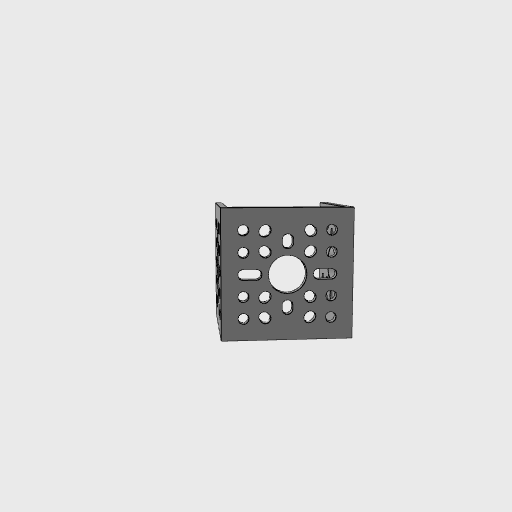

In [ ]:
dataset[2]["image"]

In [ ]:
instruction = "Identify the GoBilda part shown in this image without further elaboration."

def conversation_template(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["label"]}]},
    ]
    return {"messages": conversation}

converted_dataset = [conversation_template(sample) for sample in dataset]

In [ ]:
FastVisionModel.for_inference(model)

image = dataset[2]["image"]

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.0,
    top_p=0.95,
    top_k=64
)

The image shows aGoBilda 3060105804432/090A27, which is a part that integrates with the GoBilda door entry system (RDC series). This particular product code corresponds to an access control module used for entering and exiting buildings via the GoBilda home security or access system (RDC series), with a specific model and manufacturer designation mentioned by the end numbers '3060105804432/090A27'. For accurate installation and replacement purposes, always refer to the official user manual provided


In [ ]:
import torch
from trl import SFTTrainer, SFTConfig
from unsloth.trainer import UnslothVisionDataCollator

FastVisionModel.for_training(model)  # Enable for training!
torch._dynamo.config.cache_size_limit = 32

trainer = SFTTrainer(
    model=model,
    tokenizer=processor,
    data_collator=UnslothVisionDataCollator(model, processor),  # Must use!
    train_dataset=converted_dataset,
    args=SFTConfig(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        # max_steps=30,
        num_train_epochs = 5, # Set this instead of max_steps for full training runs
        learning_rate=2e-4,
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=7043,
        output_dir="outputs",
        report_to="none",  # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        max_seq_length=2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [ ]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 3070 Laptop GPU. Max memory = 8.0 GB.
4.137 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,024 | Num Epochs = 5 | Total steps = 320
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 82,169,856 of 3,836,792,832 (2.14% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,8.073200
2,8.065400
3,7.853600
4,6.974900
5,5.437300
6,4.082400
7,3.209800
8,2.474500
9,1.928600
10,1.388800


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

2989.2084 seconds used for training.
49.82 minutes used for training.
Peak reserved memory = 4.855 GB.
Peak reserved memory for training = 0.718 GB.
Peak reserved memory % of max memory = 60.688 %.
Peak reserved memory for training % of max memory = 8.975 %.


In [ ]:
model.save_pretrained("fl_lora_2d")  # Local saving
processor.save_pretrained("fl_lora_2d")

[]

In [ ]:
FastVisionModel.for_inference(model)

image = dataset[2]["image"]

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.0,
    top_p=0.95,
    top_k=64
)

UChannel1H<|im_end|>
